In [35]:
from sklearn.tree import DecisionTreeClassifier
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
from sklearn.model_selection import train_test_split

def initialize_stump():
    stump = DecisionTreeClassifier(criterion='entropy', max_depth=1)
    return stump


In [47]:
# Adaboost classifier
class AdaBoostClassifier:
    def __init__(self, n_learners):
        self.n_learner = n_learners
        self.weights = None
        self.learners = []
        self.coefficents = []
        
    def fit(self, X, y):
        self.weights = 1 / y.shape[0] * np.ones((y.shape[0],))
        
        
        for i in range(self.n_learner):
            learner = initialize_stump()
            learner.fit(X, y, sample_weight= self.weights)
            y_hat = learner.predict(X)
            error = self.weighted_error(y , y_hat)
            expansion_coefficent = np.log((1 - error)/error)
            self.weights = self.weights* np.exp(expansion_coefficent * (y != y_hat))
            self.learners.append(learner)
            self.coefficents.append(expansion_coefficent)
            
    def predict(self, X):
        y_hat = np.zeros((X.shape[0],))
        for learner , coef in zip(self.learners, self.coefficents):
            y_hat += coef*(2 * learner.predict(X) -1)
        y_hat = (((np.sign(y_hat)) +1)/2).astype(int)
        return y_hat
            
    def weighted_error(self, y, y_hat):
        return np.sum((y != y_hat).astype(float) * self.weights)/np.sum(self.weights)

In [51]:
# Data preprocessing 
# Titanic dataset from Kaggle
class TitanicDataset():
    
    @property
    def feature_names(self):
        return ['Sex', 'Age', 'Fare', 'Title_Master', 'Title_Miss', 
                'Title_Mr', 'Title_Mrs', 'Title_Rare', 'Pclass_1', 'Pclass_2',
                'Pclass_3', 'IsAlone', 'Embarked_C', 'Embarked_Q', 'Embarked_S']
    
    @property
    def class_names(self):
        return ['survived', 'dead']
    
    def load(self):
        df = pd.read_csv('titanic.csv')
    
        # The feature engineering mostly follows the notebook by Manav Segal: https://www.kaggle.com/startupsci/titanic-data-science-solutions
        # From the Name attribute we can extract titles, which gives insight about the social status/age/gender of the passenger.
        df['Title'] = df['Name'].str.extract(' ([a-zA-Z]+)\.', expand=False)
        df['Title'] = df['Title'].replace(['Lady', 'Countess', 'Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
        df['Title'] = df['Title'].replace(['Mlle', 'Ms'], 'Miss')
        df['Title'] = df['Title'].replace('Mme', 'Mrs')
        
        # We map the Title attribute to a one-hot encoding.
        df = df.join(pd.get_dummies(df['Title'], prefix='Title'))
    
        
        # We map the Sex attribute to a numeric representation.
        df['Sex'] = df['Sex'].map({'female': 1, 'male': 0}).astype(int)
    
        
        # We one-hot encode Pclass.
        df = df.join(pd.get_dummies(df['Pclass'], prefix='Pclass'))
    
        
        # Based on the number of sibling-spouses in SibSp and parents-childern in Parch, 
        # we can determine whether a passenger was on board alone.
        df['IsAlone'] = ((df['SibSp'] + df['Parch'] + 1) == 1).astype(int)
    
        
        # We remove all attributes that do not seem relevant to the prediction, or are already encoded in another attribute.
        df = df.drop(['PassengerId', 'Name', 'Title', 'Ticket', 'Cabin', 'Parch', 'SibSp'], axis=1)
    
        # For remaining features, we have to separate train and test, 
        # as we will impute missing data based on statistics in the training data.
        df_train, df_test = train_test_split(df, test_size=0.2, random_state=2024)
        # For Embarked, we set all missing values to the most frequent port and then one-hot encode the attribute.
        def impute_embarked():    
            freq_port = df_train['Embarked'].dropna().mode()[0]
            output = []
            for df in (df_train, df_test):
                df = df.join(pd.get_dummies(df['Embarked'].fillna(freq_port), prefix='Embarked'))
                df = df.drop('Embarked', axis=1)
                output.append(df)
            return output
    
        df_train, df_test = impute_embarked()
    
        # For Age, we set missing values to the median dependent on the pair of Sex and Pclass.
        guess_ages = np.zeros((2, 3))
        for df in (df_train, df_test):
            for i in range(2):
                for j in range(3):
                    guess_ages[i, j] = df[(df['Sex'] == i) & (df['Pclass'] == j+1)]['Age'].dropna().median()
            for i in range(2):
                for j in range(3):
                    df.loc[(df['Age'].isnull()) & (df['Sex'] == i) & (df['Pclass'] == j+1), 'Age'] = guess_ages[i, j]
            df['Age'] = df['Age'].astype(int)
    
        df_train = df_train.drop(['Pclass'], axis=1)
        df_test = df_test.drop(['Pclass'], axis=1)
    
        X_train = df_train.values[:, 1:]
        X_test = df_test.values[:, 1:]
        y_train = df_train.values[:, 0]
        y_test = df_test.values[:, 0]
        
        # convert the dtypes
        y_train = np.asarray(y_train, dtype='int')
        y_test = np.asarray(y_test, dtype='int')
        
        self._X_train = X_train
        self._X_test = X_test
        self._y_train = y_train
        self._y_test = y_test
        
        return X_train, X_test, y_train, y_test

In [52]:
titanic_data = TitanicDataset()
# X_train, X_test, y_train, y_test = titanic_data.load()


In [53]:
# Hyper parameter tuning for number of learners
def evaluate_adaboost_for_different_size(dataset, number_of_learners= None):
    
    if number_of_learners is None:
        number_of_learners = list(range(1, 100, 1))
    
    f1scores = []
    best_adaboost = None
    X_train, X_test, y_train, y_test = dataset.load()
    
    for l in number_of_learners:
        adaboost = AdaBoostClassifier(l)
        adaboost.fit(X_train, y_train)
        yhat = adaboost.predict(X_test)
        f1score = precision_recall_fscore_support(y_test, yhat, average='micro')[2]
        if f1score > max(f1scores + [0.0]):
            best_adaboost = adaboost
        f1scores.append(f1score)
    
    best_adaboost_idx = np.argmax(f1scores)
    best_f1score = f1scores[best_adaboost_idx]
    print(f'Best F1-score {best_f1score:.02f} for number_of_trees = {number_of_learners[best_adaboost_idx]}.')
    
    fig, ax = plt.subplots()
    ax.plot(number_of_learners, f1scores)
    ax.set_xlabel('number of learners')
    ax.set_ylabel('F1 (micro)')
    ax.set_title('F1-score for different numbers of learners')
    
    return best_adaboost


Best F1-score 0.82 for number_of_trees = 28.


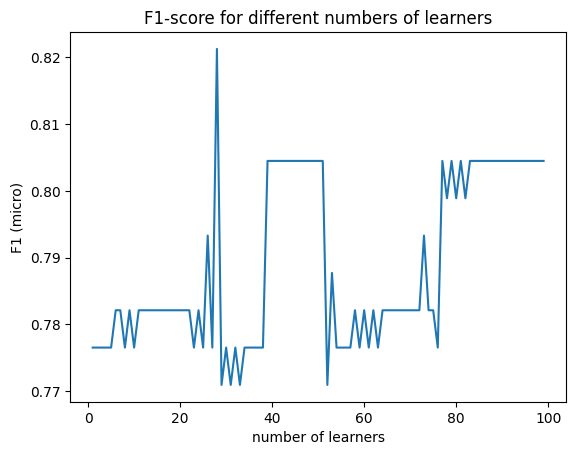

In [48]:
best_adaboost = evaluate_adaboost_for_different_size(titanic_data)